In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from time import time
from IPython.display import clear_output
import sys
import psutil
import seaborn as sb
import pickle
import warnings
from scipy.stats import entropy
from sklearn.cluster import DBSCAN, KMeans
import SpaGFT as spagft
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, ConfusionMatrixDisplay
warnings.filterwarnings('ignore')

In [2]:
# Loading data
path_to_mouse_brain_data = '/sbgenomics/project-files/Mouse_brain_cell_bin.h5ad'
adata = sc.read_h5ad(path_to_mouse_brain_data)

In [3]:
# Preprocessing

sc.pp.filter_genes(adata, min_cells=30)
print('Filtered genes')

sc.pp.normalize_total(adata, inplace=True)
print('Normalized')

sc.pp.log1p(adata)
print('logd')

adata.X_array = adata.X.toarray()
print('Added Array')

Filtered genes
Normalized
logd
Added Array


In [7]:
# Multiprocessing za gene sa malo celija obradjene klasterizacijom

from collections import defaultdict
import multiprocessing
from math import ceil
from time import sleep
import gc 
import psutil

class SVG_finder_process(multiprocessing.Process):
    
    def __init__(self, adata, queue, categories, process_index, process_name):
        multiprocessing.Process.__init__(self)
        
        self.tissue_names = categories
        self.adata = adata
        self.var_names = adata.var_names
        self.annotations = adata.obs['annotation']
        self.X = adata.X.toarray()
        self.queue = queue
        self.process_index = process_index
        self.process_name = process_name
        
        print(f'Process {self.name} initialized')

    def varOfMean_metric(self, gene_name):
       
        gene_data = self.X[:, self.adata.var_names == gene_name]
        
        # Calculate the mean of gene expression in every tissue
        mean_values = []
        for i, c in enumerate(self.tissue_names):
            data = gene_data[self.adata.obs['annotation'] == c][:, None]            
            mean_values.append(np.mean(data))
        
        # Return the variance of mean values
        treshold = 0.0015
        return np.var(mean_values), treshold
    
    def varOfEntropy_metric(self, gene_name):
       
        gene_data = self.X[:, self.adata.var_names == gene_name]
        
        # Calculate the entropy of gene expression in every tissue
        entropy_values = []
        for i, c in enumerate(self.tissue_names):
            data = gene_data[self.adata.obs['annotation'] == c][:, None]
            # Calculate the histogram
            hist_values, _ = np.histogram(data, bins='auto')
            # Normalize the histogram to obtain the probability distribution
            pdf = hist_values / np.sum(hist_values)
            
            entropy_values.append(entropy(pdf))
        
        # Return the variance of entropy values
        treshold = 0.03
        return np.var(entropy_values), treshold        
    
    def average_metric(self, gene_name):
       
        gene_data = self.X[:, self.var_names == gene_name]
        
        gene_data = gene_data / gene_data.max()  # Normalizing gene expressions
        
        # Calcululate difference of means in tissue and outside of tissue for all tissues
        differences = np.empty(len(self.tissue_names))
        for tissue_index, tissue_name in enumerate(self.tissue_names):
            

            mean_inside_tissue = gene_data[self.annotations == tissue_name].mean()
            mean_outside_tissue = gene_data[self.annotations != tissue_name].mean()
            differences[tissue_index] = mean_inside_tissue - mean_outside_tissue
                
        
        # We find the maximum difference between tissue and not tissue means and normalize it
        maximum_normalized_mean_difference = np.max(differences) # gene_mean_organism
        treshold = 0.035
        
        return maximum_normalized_mean_difference, treshold
    
    
    def clustering_metric(self, gene, gene_expressed_vector):
        
        gene_data = self.adata[:, self.var_names == gene]
        gene_X = self.X[:, self.var_names == gene]
        
        
        gene_expressed_vector = (gene_X > 0).flatten()
        gene_cell_num = gene_expressed_vector.sum() 
        gene_clustering_data = gene_data[gene_expressed_vector] # Only cells with expressed gene are clustered
        
        clustering = DBSCAN(eps=250, min_samples=4).fit(gene_clustering_data.obsm['spatial'])
        labels = clustering.labels_
        cluster_ids = set(labels)
        
        # For each cluster
        all_tissues = set()  # Tissues where gene is expressed
        for cluster_id in cluster_ids:
            
            if cluster_id == -1:  # Skipping noise
                continue
                
            cluster_cells = labels == cluster_id
            cluster_size = (cluster_cells).sum() # Calculating number of cells
             
            # If cluster is big enough see in how many tissues it spans
            if cluster_size > 1000:
                return True
                
        return False
        
    
    
    def run(self):
        
       
        svg_vector = []
        percentage_done = 0
        num_genes = len(self.var_names)
        
        for gene_index, gene in enumerate(self.var_names):
            
            gene_X = self.X[:, self.var_names == gene]
            gene_expressed_vector = (gene_X > 0).flatten()
            gene_cell_num = gene_expressed_vector.sum()
            gene_data = self.adata[:, self.var_names == gene]
            
            
            if gene_cell_num > 2000:
                metric, treshold = self.varOfMean_metric(gene)
                svg_vector.append(metric > treshold)
            else:
                metric = self.clustering_metric(gene, gene_expressed_vector)
                svg_vector.append(metric)
            
            
            if gene_index / num_genes * 100 > percentage_done:
                gc.collect()
                print(f"{self.name} done {percentage_done}% current RAM used = {psutil.virtual_memory()[3]/1000000000}")
                percentage_done += 10
        
        svg_vector = np.array(svg_vector)
        
        
        print(f"{self.name} finished")
        gene_max = self.queue.get()
        gene_max[self.process_index] = True
        gene_max[str(self.process_name) + 'res'] = svg_vector
        self.queue.put(gene_max)
        

        
start = time()    


num_processes = 3
# Flags which are set when process is finished
common_dict = {i : False for i in range(num_processes)}
common_dict['positives'] = 0
common_dict['negatives'] = 0

processes = []

genes_length = len(adata.var_names)
batch_size = ceil(genes_length / num_processes)  # batch of genes given to each process
queue = multiprocessing.Queue(1)
queue.put(common_dict)

categories = np.unique(adata.obs['annotation'])


for process_index in range(num_processes):
    
    
    # Adding 0s to process names so 'proces09' would come before 'process10' when sorting names
    process_name = str(process_index)
    for _ in range(len(str(num_processes)) - len(process_name)):
        process_name = '0' + process_name
    process_name = "Process " + process_name
    
    start_index = process_index * batch_size
    if process_index == num_processes - 1: # last process batch may be shorter
        end_index = genes_length
    else:
        end_index = start_index + batch_size
    
    adata_for_process = adata[:, start_index : end_index]
    
    process = SVG_finder_process(adata_for_process, queue, categories, process_index, process_name)
    processes.append(process)
    

    
for process in processes:
    process.start()
    

finished_processes = 0
while finished_processes < num_processes:
    gene_max = queue.get()
    queue.put(gene_max)
    if gene_max[finished_processes]:
        finished_processes += 1
    else:
        sleep(1)




print(f'Finished in {time() - start} seconds')

Process SVG_finder_process-4 initialized
Process SVG_finder_process-5 initialized
Process SVG_finder_process-6 initialized
SVG_finder_process-4 done 0% current RAM used = 15.224119296
SVG_finder_process-5 done 0% current RAM used = 15.25764096
SVG_finder_process-6 done 0% current RAM used = 15.262687232
SVG_finder_process-5 done 10% current RAM used = 15.280439296
SVG_finder_process-4 done 10% current RAM used = 15.280439296
SVG_finder_process-6 done 10% current RAM used = 15.280943104
SVG_finder_process-5 done 20% current RAM used = 15.280594944
SVG_finder_process-4 done 20% current RAM used = 15.281864704
SVG_finder_process-6 done 20% current RAM used = 15.282372608
SVG_finder_process-5 done 30% current RAM used = 15.283515392
SVG_finder_process-4 done 30% current RAM used = 15.283601408
SVG_finder_process-6 done 30% current RAM used = 15.28449024
SVG_finder_process-5 done 40% current RAM used = 15.285403648
SVG_finder_process-4 done 40% current RAM used = 15.286165504
SVG_finder_pro

In [8]:
# Joining the results from multiple processes
# When this cell executes results can be found in all_data variable

keys = [key for key in gene_max if 'res' in str(key)]
keys = sorted(keys)

x_axis_len = sum([gene_max[key].shape[0] for key in keys])
all_data = np.empty(x_axis_len)
starting_index = 0

for key in keys:
    data = gene_max[key]
    data_len = data.shape[0]
    
    all_data[starting_index : starting_index + data_len] = data
    starting_index += data_len


Confusion matrix:
 [[14740   986]
 [  850   950]]
F1 score:  0.5085653104925053
AUC : 0.7325395311373945


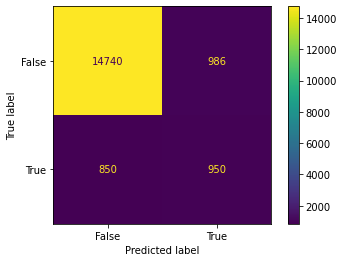

In [9]:
# Comparing results with SpaGFT
# Path to .pkl file containing set of SVGs found by SpaGFT should be provided in variable path_to_spagft_svgs
# When this cell executes, a confusion matrix, F1-score and AUC metric will be displayed
path_to_spagft_svgs = 'SVG_SpaGFT'

SVGs = adata.var_names[all_data.astype(bool)]

with open(path_to_spagft_svgs, 'rb') as f:
    svg_spagft = pickle.load(f)
    
set1 = set(svg_spagft) 
set2 = set(SVGs)

true_labels = [gene in set1 for gene in adata.var_names]
preds = [gene in set2 for gene in adata.var_names]
cm = confusion_matrix(true_labels, preds)
f1 = f1_score(true_labels, preds)
auc = roc_auc_score(true_labels, preds)
print('Confusion matrix:\n', cm)
print('F1 score: ', f1)
print('AUC :', auc)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[False, True])
cm_display.plot()
plt.show()